In [8]:
# Cell 1  – ONLY imports & helpers appear here
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pickle, pathlib, datetime, tqdm

SAVE_ROOT = pathlib.Path('.') / 'models'
SAVE_ROOT.mkdir(exist_ok=True)

def build_model():
    m = keras.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(2, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(2, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

# single reference training (10
np.random.seed(42)
x_single = np.random.uniform(0, 100, (10_000, 1)).astype(np.float32)
y_single = np.exp(x_single).astype(np.float32)

single_model = build_model()
single_model.fit(x_single, y_single,
                 epochs=10, batch_size=32,
                 validation_split=0.20, verbose=1)

ts          = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
model_path  = SAVE_ROOT / f'exp_model_{ts}.keras'
wb_path     = SAVE_ROOT / f'exp_model_weights_{ts}.pkl'

single_model.save(model_path)
print('✓ saved model to', model_path)

wb = {f'layer_{i:02d}': {'weights': w, 'biases': b}
      for i, (w, b) in enumerate(ly.get_weights()
                                  for ly in single_model.layers)
      if len(w) > 0}

with open(wb_path, 'wb') as f:
    pickle.dump(wb, f)
print('✓ saved reference weights/biases to', wb_path)



Epoch 1/10


<ipython-input-8-fab28a303065>:26: RuntimeWarning: overflow encountered in exp
  y_single = np.exp(x_single).astype(np.float32)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - val_loss: nan
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - val_loss: nan
✓ saved model to models/exp_model_20250523_154648.keras
✓ saved reference weights/biases to models/exp_model_weights_20250523_154648.pkl


In [12]:
# Cell 2  – Monte-Carlo experiment  (fixed for older NumPy)

N_RUNS      = 10
EPOCHS_EACH = 30
AGG_PATH    = SAVE_ROOT / 'wb_distribution.pkl'
CSV_PATH    = SAVE_ROOT / 'wb_distribution.csv'

records = []

for run in tqdm.tqdm(range(N_RUNS)):
    rng = np.random.default_rng(1_000 + run)

    # generate, then cast -----
    x = rng.uniform(0, 100, size=(10_000, 1)).astype(np.float32)
    y = np.exp(x).astype(np.float32)
    # ------------------------------------

    m = build_model()
    m.fit(x, y, epochs=EPOCHS_EACH, batch_size=32,
          validation_split=0.20, verbose=0)

    for layer_idx, layer in enumerate(m.layers):
        if not layer.trainable_weights:
            continue
        W, b = layer.get_weights()
        records.extend(
            {"run": run, "layer": layer_idx, "param": "weight", "value": v}
            for v in W.flatten().astype(np.float32)
        )
        records.extend(
            {"run": run, "layer": layer_idx, "param": "bias", "value": v}
            for v in b.astype(np.float32)
        )

df = pd.DataFrame.from_records(records)
df.to_pickle(AGG_PATH)
df.to_csv(CSV_PATH, index=False)
print("✓ stored aggregated data to", AGG_PATH, "and", CSV_PATH)


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-12-a457e17205ff>:15: RuntimeWarning: overflow encountered in exp
  y = np.exp(x).astype(np.float32)
100%|██████████| 10/10 [05:01<00:00, 30.20s/it]

✓ stored aggregated data to models/wb_distribution.pkl and models/wb_distribution.csv


In [22]:
# Cell 3  – load the aggregated Monte-Carlo results
df = pd.read_pickle(SAVE_ROOT / 'wb_distribution.pkl')
print("DataFrame shape:", df.shape)
df.head()


DataFrame shape: (360, 4)


,run,layer,param,value
0,0,0,weight,NaN
1,0,0,weight,NaN
2,0,0,bias,NaN
3,0,0,bias,NaN
4,0,1,weight,NaN


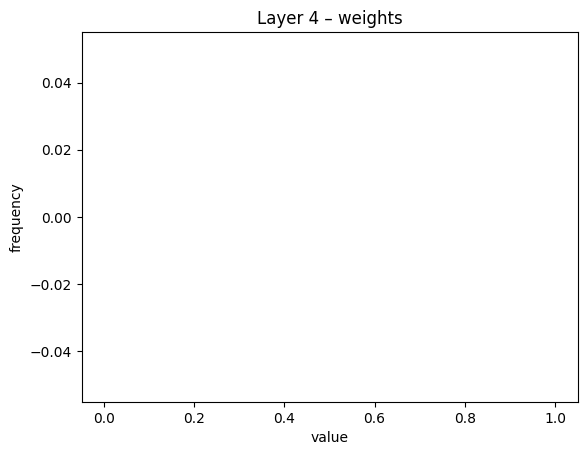

In [23]:
# Cell 4  – histograms using pandas’ built-in plot wrapper
for (layer, param), g in df.groupby(["layer", "param"]):
    ax = g["value"].plot.hist(
        bins=50, alpha=0.75,
        title=f"Layer {layer} – {param}s"
    )
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")


In [24]:
!pwd


/content
